<a href="https://www.kaggle.com/code/dalloliogm/ensembling-multiple-strategies?scriptVersionId=272207963" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 5 different ensembling strategies 


Inspired by https://www.kaggle.com/code/paharpurailab/predicting-road-accident-risk-blending. Thanks for sharing!

Notebooks used for the ensembling:
- https://www.kaggle.com/code/anthonytherrien/ps-s5e10-lightgbm-cb-ensemble/output
- https://www.kaggle.com/code/aliffaagnur/road-accident-risk-autogluon/notebook
- https://www.kaggle.com/code/anthonytherrien/road-accident-risk-blend
- https://www.kaggle.com/code/kmmmvs/5-10-merging-lgbm-and-ydf

[I 2025-10-30 20:10:34,270] A new study created in memory with name: no-name-7cf971e8-d4dd-4f6b-9a36-95c7a1ce3c05
[I 2025-10-30 20:10:34,283] Trial 0 finished with value: 0.18519764463748395 and parameters: {'w0': 0.6480254797567457, 'w1': 0.14061481510649398, 'w2': 0.9415780932645489, 'w3': 0.8675798817769877}. Best is trial 0 with value: 0.18519764463748395.
[I 2025-10-30 20:10:34,285] Trial 1 finished with value: 0.046511693223548284 and parameters: {'w0': 0.8409873961498124, 'w1': 0.8011153422354836, 'w2': 0.4530837943884931, 'w3': 0.7956590734896103}. Best is trial 1 with value: 0.046511693223548284.
[I 2025-10-30 20:10:34,286] Trial 2 finished with value: 0.11762573906632436 and parameters: {'w0': 0.5658995834309389, 'w1': 0.35389441815008416, 'w2': 0.18867275272432493, 'w3': 0.4139756372433331}. Best is trial 1 with value: 0.046511693223548284.
[I 2025-10-30 20:10:34,288] Trial 3 finished with value: 0.2922836705140108 and parameters: {'w0': 0.25510453779038755, 'w1': 0.86384489

✅ Loaded 4 submissions, 172,585 rows.


[I 2025-10-30 20:10:34,331] Trial 12 finished with value: -0.020556854765914352 and parameters: {'w0': 0.7511858847697869, 'w1': 0.6088146816779497, 'w2': 0.6665489582140482, 'w3': 0.6195705041304386}. Best is trial 12 with value: -0.020556854765914352.
[I 2025-10-30 20:10:34,339] Trial 13 finished with value: 0.04252788375648206 and parameters: {'w0': 0.802812485574514, 'w1': 0.9716691241885278, 'w2': 0.6210612567589555, 'w3': 0.5810518254026208}. Best is trial 12 with value: -0.020556854765914352.
[I 2025-10-30 20:10:34,347] Trial 14 finished with value: 0.05090314325325815 and parameters: {'w0': 0.6520450650984062, 'w1': 0.9959582581520962, 'w2': 0.707320838403192, 'w3': 0.5551819792544225}. Best is trial 12 with value: -0.020556854765914352.
[I 2025-10-30 20:10:34,356] Trial 15 finished with value: 0.08428185229683809 and parameters: {'w0': 0.4316402347232706, 'w1': 0.9929966054833609, 'w2': 0.7057358256509222, 'w3': 0.6363360674293731}. Best is trial 12 with value: -0.020556854765

💾 Saved submission_simple.csv
💾 Saved submission_rankavg.csv
💾 Saved submission_logit.csv
💾 Saved submission_corrconf.csv
💾 Saved submission_optuna.csv

Final Weights:
  Conf:      [0.25 0.25 0.25 0.25]
  CorrConf:  [0.336  0.1681 0.3278 0.168 ]
  Optuna:    [0.2503 0.2499 0.2502 0.2496]


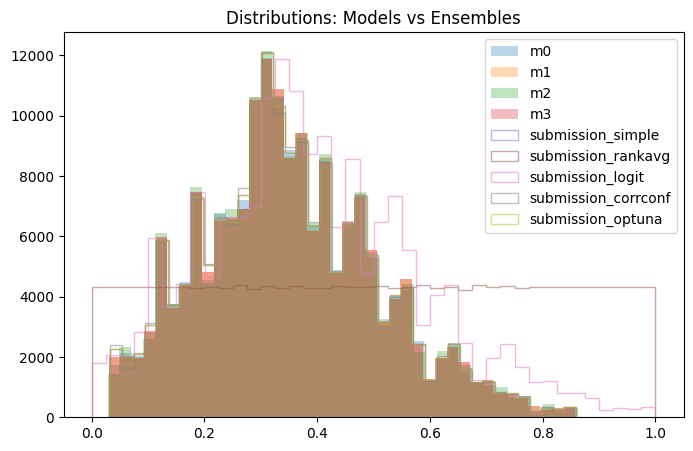

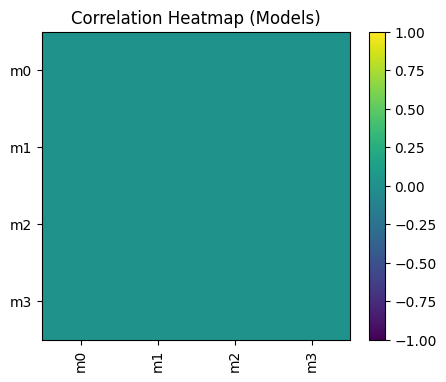

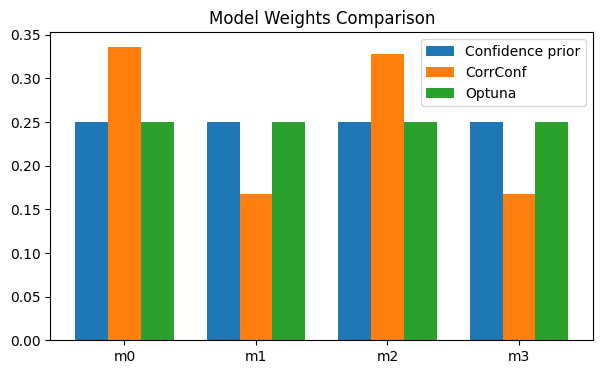


✅ 5 submission files generated successfully.


In [1]:
# ======================================================
# ⚙️ Three Ensemble Strategies + Diagnostics (Matplotlib)
# ======================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna

# ---------- 0) CONFIG ----------
# List your submission files and (optional) public RMSEs.
files = [
    '/kaggle/input/playground-5-10-top-submissions/submission aliffa agnur autogluon16.csv',
    '/kaggle/input/playground-5-10-top-submissions/submission anthonythierren cb ensemble.csv',
    '/kaggle/input/playground-5-10-top-submissions/submission sung hur.csv',
    '/kaggle/input/playground-5-10-top-submissions/submission.csv'
]
public_rmse = [0.05539, 0.05539, 0.05540, 0.05538]  # if unknown, set all equal

target_col = 'accident_risk'
id_col = 'id'
clip_min, clip_max = 1e-6, 1 - 1e-6
seed = 42
np.random.seed(seed)

# ---------- 1) LOAD ----------
subs = [pd.read_csv(f) for f in files]
base = subs[0][[id_col]].copy()
for i, s in enumerate(subs):
    base = base.merge(s[[id_col, target_col]].rename(columns={target_col: f'm{i}'}), on=id_col, how='inner')

ids = base[id_col].values
preds = base[[c for c in base.columns if c.startswith('m')]].values
M = preds.shape[1]
print(f"✅ Loaded {M} submissions, {len(ids):,} rows.")

# ---------- 2) UTILS ----------
def minmax01(x):
    mn, mx = x.min(), x.max()
    return (x - mn) / (mx - mn + 1e-12)

def safe_logit(p):
    p = np.clip(p, clip_min, clip_max)
    return np.log(p / (1 - p))

def safe_sigmoid(z):
    return 1 / (1 + np.exp(-z))

def to_ranks01(X):
    R = np.empty_like(X, dtype=float)
    n = X.shape[0]
    for j in range(X.shape[1]):
        order = np.argsort(X[:, j])
        ranks = np.empty(n)
        ranks[order] = np.arange(n)
        R[:, j] = ranks / (n - 1)
    return R

def pearson_corr_matrix(X):
    Xc = X - X.mean(0)
    return (Xc.T @ Xc) / (X.shape[0] - 1 + 1e-9)

# ---------- 3) ENSEMBLE STRATEGIES ----------

# (1) Simple Average
ens_simple = preds.mean(axis=1)

# (2) Rank Averaging (robust)
ranks = to_ranks01(preds)
ens_rankavg = ranks.mean(axis=1)

# (3) Logit (Geometric) Averaging
norm01 = np.column_stack([minmax01(preds[:, j]) for j in range(M)])
ens_logit = safe_sigmoid(safe_logit(norm01).mean(axis=1))

# (4) Correlation-Aware Weighted Average
conf = np.exp(-np.array(public_rmse))
conf = conf / conf.sum()
C = pearson_corr_matrix(preds)
avg_corr = (C.sum(axis=1) - 1.0) / max(M - 1, 1)
diverse = 1.0 / (1e-6 + (avg_corr - avg_corr.min()) / (avg_corr.max() - avg_corr.min() + 1e-9) + 1.0)
raw_w = conf * diverse
w_corrconf = raw_w / raw_w.sum()
ens_corrconf = preds @ w_corrconf

# (5) Optuna Fine-Tuned Weights
def objective(trial):
    w = np.array([trial.suggest_float(f"w{i}", 0.0, 1.0) for i in range(M)])
    w /= w.sum() + 1e-9
    prior_term = np.sqrt(((w - conf) ** 2).sum())
    corr_term = float(w @ C @ w)
    entropy = -np.sum(w * np.log(w + 1e-9))
    return prior_term + 0.25 * corr_term - 0.05 * entropy

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=200, show_progress_bar=False)
w_opt = np.array([study.best_params[f"w{i}"] for i in range(M)])
w_opt /= w_opt.sum()
ens_optuna = preds @ w_opt

# ---------- 4) SAVE FIVE SUBMISSIONS ----------
ensembles = {
    'submission_simple.csv': ens_simple,
    'submission_rankavg.csv': ens_rankavg,
    'submission_logit.csv': ens_logit,
    'submission_corrconf.csv': ens_corrconf,
    'submission_optuna.csv': ens_optuna,
}

for fname, vec in ensembles.items():
    pd.DataFrame({id_col: ids, target_col: vec}).to_csv(fname, index=False)
    print(f"💾 Saved {fname}")

print("\nFinal Weights:")
print(f"  Conf:      {np.round(conf, 4)}")
print(f"  CorrConf:  {np.round(w_corrconf, 4)}")
print(f"  Optuna:    {np.round(w_opt, 4)}")

# ---------- 5) PLOTS ----------

plt.figure(figsize=(8,5))
for j in range(M):
    plt.hist(preds[:, j], bins=40, alpha=0.3, label=f'm{j}')
for name, vec in ensembles.items():
    plt.hist(vec, bins=40, alpha=0.5, label=name.split('.')[0], histtype='step')
plt.title('Distributions: Models vs Ensembles')
plt.legend()
plt.show()

plt.figure(figsize=(5,4))
im = plt.imshow(pearson_corr_matrix(preds), vmin=-1, vmax=1)
plt.title('Correlation Heatmap (Models)')
plt.colorbar(im)
plt.xticks(range(M), [f'm{i}' for i in range(M)], rotation=90)
plt.yticks(range(M), [f'm{i}' for i in range(M)])
plt.show()

plt.figure(figsize=(7,4))
x = np.arange(M)
bw = 0.25
plt.bar(x - bw, conf, width=bw, label='Confidence prior')
plt.bar(x, w_corrconf, width=bw, label='CorrConf')
plt.bar(x + bw, w_opt, width=bw, label='Optuna')
plt.title('Model Weights Comparison')
plt.xticks(x, [f'm{i}' for i in range(M)])
plt.legend()
plt.show()

print("\n✅ 5 submission files generated successfully.")